# 12 - Doubly Robust Estimation

## Don't Put All your Eggs in One Basket

We've learned how to use linear regression and propensity score weighting to estimate $E[Y|T=1] - E[Y|T=0] | X$. But which one should we use and when? When in doubt, just use both! Doubly Robust Estimation is a way of combining propensity score and linear regression in a way you don't have to rely on either of them. 

To see how this works, let's consider the mindset experiment. It is a randomised study conducted in U.S. public high schools which aims at finding the impact of a growth mindset. The way it works is that students receive from the school a seminar to instil in them a growth mindset. Then, they follow up with the students in their college years to measure how well they performed academically. This measurement was compiled into an achievement score and standardised. The real data on this study is not publicly available in order to preserve students' privacy. However, we have a simulated dataset with the same statistical properties provided by [Athey and Wager](https://arxiv.org/pdf/1902.07409.pdf), so we will use that instead.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


Although the study was randomised, it doesn't seem to be the case that this data is free from confounding. One possible reason for this is that the treatment variable is measured by the student's receipt of the seminar. So, although the opportunity to participate was random, participation is not. We are dealing with a case of non-compliance here. One evidence of this is how the student's success expectation is correlated with the participation in the seminar. Students with higher self-reported high expectations are more likely to have joined the growth mindset seminar.

In [3]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

As we know by now, we could adjust for this using a linear regression or by estimating a propensity score model with a logistic regression. Before we do that, however, we need to convert the categorical variables to dummies.

In [4]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


We are now ready to understand how doubly robust estimation works.

## Doubly Robust Estimation

![img](./data/img/doubly-robust/double.png)

Instead of deriving the estimator, I'll first show it to you and only then tell why it is awesome.

$
\hat{ATE} = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg) - \frac{1}{N}\sum \bigg( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \bigg)
$

where $\hat{P}(x)$ is an estimation of the propensity score (using logistic regression, for example), $\hat{\mu_1}(x)$ is an estimation of $E[Y|X, T=1]$ (using linear regression, for example), and $\hat{\mu_0}(x)$ is an estimation of $E[Y|X, T=0]$. As you might have already guessed, the first part of the doubly robust estimator estimates $E[Y_1]$ and the second part estimates $E[Y_0]$. Let's examine the first part, as all the intuition will also apply to the second part by analogy.

Since I know that this formula is scary at first (but don't worry, you will see it is super simple), I will first show how to code this estimator. I have the feeling that some people are less frightened by code than by formulas. Let's see how this estimator works in practice, shall we?

In [5]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [6]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

0.3882219657560294

Doubly robust estimator is saying that we should expect individuals who attended the mindset seminar to be 0.388 standard deviations above their untreated fellows, in terms of achievements. Once again, we can use bootstrap to construct confidence intervals.

In [7]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [8]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (0.3536550089788505, 0.41978380616491434)


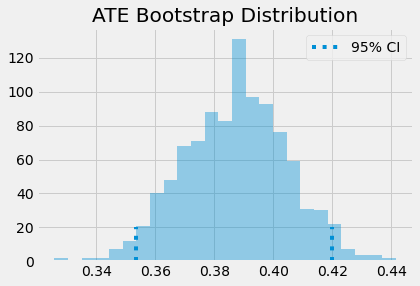

In [9]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

Now that we got a taste of the doubly robust estimator, let's examine why it is so great. First, it is called doubly robust because it only requires one of the models, $\hat{P}(x)$ or $\hat{\mu}(x)$, to be correctly specified. To see this, take the first part that estimates $E[Y_1]$ and take a good look at it.

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

Assume that $\hat{\mu_1}(x)$ is correct. If the propensity score model is wrong, we wouldn't need to worry. Because if $\hat{\mu_1}(x)$ is correct, then $E[T_i(Y_i - \hat{\mu_1}(X_i))]=0$. That is because the multiplication by $T_i$ selects only the treated and the residual of $\hat{\mu_1}$ on the treated have, by definition, mean zero. This causes the whole thing to reduce to $\hat{\mu_1}(X_i)$, which is correctly estimated $E[Y_1]$ by assumption. So, you see, that by being correct, $\hat{\mu_1}(X_i)$ wipes out the relevance of the propensity score model. We can apply the same reasoning to understand the estimator of $E[Y_0]$. 

But don't take my word for it. Let the code show you the way! In the following estimator, I've replaced the logistic regression that estimates the propensity score by a random uniform variable that goes from 0.1 to 0.9 (I don't want very small weights to blow up my propensity score variance). Since this is random, there is no way it is a good propensity score model, but we will see that the doubly robust estimator still manages to produce an estimation that is very close to when the propensity score was estimated with logistic regression.

In [10]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [11]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

0.37970260273783474

If we use bootstrap, we can see that the variance is slightly higher than when the propensity score was estimated with a logistic regression.

In [12]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_ps)
wrong_ps = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                              for _ in range(bootstrap_sample))
wrong_ps = np.array(wrong_ps)

In [13]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

print(f"Wrong PS ATE 95% CI:", (np.percentile(wrong_ps, 2.5), np.percentile(wrong_ps, 97.5)))

Original ATE 95% CI: (0.3536550089788505, 0.41978380616491434)
Wrong PS ATE 95% CI: (0.33855288052541416, 0.432880812853544)


As we can see, messing up the propensity score yields slightly different ATEs, but not by much. This covers the case that the propensity model is wrong but the outcome model is correct. What about the other situation? Let's again take a good look at the first part of the estimator, but let's rearrange some terms

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \dfrac{T_i\hat{\mu_1}(X_i)}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i}{\hat{P}(X_i)} - 1\bigg) \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i - \hat{P}(X_i)}{\hat{P}(X_i)}\bigg) \hat{\mu_1}(X_i) \bigg)
$

Now, assume that the propensity score $\hat{P}(X_i)$ is correctly specified. In this case, $E[T_i - \hat{P}(X_i)]=0$, which wipes out the part dependent on $\hat{\mu_1}(X_i)$. This makes the doubly robust estimator reduce to the propensity score weighting estimator $\frac{T_iY_i}{\hat{P}(X_i)}$, which is correct by assumption. So, even if the $\hat{\mu_1}(X_i)$ is wrong, the estimator will still be correct, provided that the propensity score is correctly specified.

Once again, if you believe more in code than in formulas, here it is the practical verification. In the code below, I've replaced both regression models with a random normal variable. There is no doubt that $\hat{\mu}(X_i)$ is **not correctly specified**. Still, we will see that doubly robust estimation still manages to recover the same $\hat{ATE}$ of about 0.38 that we've seen before.

In [14]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [15]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)

0.39812549716102724

Once again, we can use bootstrap and see that the variance is just slightly higher.

In [16]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_model)
wrong_mux = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                               for _ in range(bootstrap_sample))
wrong_mux = np.array(wrong_mux)

In [17]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))
print(f"Wrong Mu ATE 95% CI:", (np.percentile(wrong_mux, 2.5), np.percentile(ates, 97.5)))

Original ATE 95% CI: (0.3536550089788505, 0.41978380616491434)
Wrong Mu ATE 95% CI: (0.33870988300540034, 0.41978380616491434)


Once more, messing up the conditional mean model alone yields only slightly different ATE. I hope I've convinced you about the power of doubly robust estimation. Its magic happens because in causal inference, there are two ways to remove bias from our causal estimates: you either model the treatment mechanism or the outcome mechanism. If either of these models are correct, you are good to go.

One caveat is that, in practice, it's very hard to model precisely either of those. More often, what ends up happening is that neither the propensity score nor the outcome model are 100% correct. They are both wrong, but in different ways. When this happens, it is not exactly settled [\[1\]](https://www.stat.cmu.edu/~ryantibs/journalclub/kang_2007.pdf) [\[2\]](https://arxiv.org/pdf/0804.2969.pdf) [\[3\]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2798744/) if it's better to use a single model or doubly robust estimation. As for me, I still like using them because at least it gives me two possibilities of being correct. 


## Key Ideas

Here, we saw a simple way of combining linear regression with the propensity score to produce a doubly robust estimator. This estimator bears that name because it only requires one of the models to be correct. If the propensity score model is correct, we will be able to identify the causal effect even if the outcome model is wrong. On the flip side, if the outcome model is correct, we will also be able to identify the causal effect even if the propensity score model is wrong.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

The data that we used was taken from the article [Estimating Treatment Effects with Causal Forests: An Application](https://arxiv.org/pdf/1902.07409.pdf), by Susan Athey and Stefan Wager. 

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).